# Met Éireann Reanalysis - compare variables

<https://www.met.ie/climate/available-data/mera>

Conversion table for accumulated variables:
<https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790>

In [1]:
# import libraries
import glob
import os
from datetime import datetime, timezone
from itertools import chain
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import xarray as xr
import climag.plot_configs as cplt

In [2]:
# Moorepark, Fermoy met station coords
LON, LAT = -8.26389, 52.16389

In [3]:
# transform coordinates from lon/lat to Lambert Conformal Conic
XLON, YLAT = cplt.lambert_conformal.transform_point(
    x=LON, y=LAT, src_crs=ccrs.PlateCarree()
)

In [4]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [5]:
# directory of processed MÉRA netCDF files
DATA_DIR = os.path.join("/run/media/nms/MyPassport", "MERA", "netcdf")

In [6]:
URL = "https://cli.fusio.net/cli/climate_data/webdata/dly575.csv"
FILE_NAME = "moorepark.csv"
DATA_FILE = os.path.join("data", "met", "MetEireann", FILE_NAME)
os.makedirs(os.path.join("data", "met", "MetEireann"), exist_ok=True)

# download Moorepark met data if necessary
if not os.path.isfile(DATA_FILE):
    pooch.retrieve(
        url=URL, known_hash=None, fname=FILE_NAME,
        path=os.path.join("data", "met", "MetEireann")
    )

    with open(f"{DATA_FILE[:-4]}.txt", "w", encoding="utf-8") as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

In [7]:
# view file
os.system(f"sed -n -e 1,26p {DATA_FILE}")

Station Name: MOORE PARK
Station Height: 46 M 
Latitude:52.164  ,Longitude: -8.264


date:  -  00 to 00 utc
rain:  -  Precipitation Amount (mm)
maxtp: -  Maximum Air Temperature (C)	  
mintp: -  Minimum  Air Temperature (C)
gmin:  -  09utc Grass Minimum Temperature (C)
soil:  -  Mean 10cm soil temperature (C)	
cbl:   -  Mean CBL Pressure (hpa)
wdsp:  -  Mean Wind Speed (kt)
hm:    -  Highest ten minute mean wind speed (kt)		                 
ddhm:  -  Wind Direction at max 10 min mean (deg)                  
hg:    -  Highest Gust (kt)
pe:    -  Potential Evapotranspiration (mm)  
evap:  -  Evaporation (mm)
smd_wd:-  Soil Moisture Deficits(mm) well drained
smd_md:-  Soil Moisture Deficits(mm) moderately drained
smd_pd:-  Soil Moisture Deficits(mm) poorly drained
glorad:-  Global Radiation (J/cm sq.)
ind:   -  Indicator (i)

date,ind,maxtp,ind,mintp,igmin,gmin,ind,rain,cbl,wdsp,ind,hm,ind,ddhm,ind,hg,soil,pe,evap,smd_wd,smd_md,smd_pd,glorad
11-aug-2003,0,21.9,0,9.6, , ,0,0.0,1017.5,4.6,

0

In [8]:
df = pd.read_csv(DATA_FILE, skiprows=24, parse_dates=["date"])
df.set_index("date", inplace=True)
df = df.loc["2003":"2005"]
# handle missing data
df.replace(" ", np.nan, inplace=True)

In [9]:
df.head()

,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,wdsp,...,ddhm,ind.5,hg,soil,pe,evap,smd_wd,smd_md,smd_pd,glorad
date,,,,,,,,,,,,,,,,,,,,,
2003-08-11,0,21.9,0,9.6,NaN,NaN,0,0.0,1017.5,4.6,...,290,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-12,0,23.5,0,8.6,NaN,NaN,0,0.0,1017.7,3.5,...,250,0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-13,0,21.8,4,NaN,NaN,NaN,8,NaN,1017.9,3.5,...,340,0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-14,0,21.0,0,7.7,NaN,NaN,0,0.0,1016.8,3.5,...,50,0,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-15,0,19.8,0,5.8,NaN,NaN,0,0.0,1015.2,2.4,...,10,0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Global irradiance

In [10]:
var = "117_105_0_4"
file_list = list(chain(*list(
    glob.glob(os.path.join(DATA_DIR, f"{var}_FC3hr", e))
    for e in [f"*{i}*{var}_FC3hr*" for i in range(2003, 2006)]
)))
data = xr.open_mfdataset(file_list, chunks="auto", decode_coords="all")

In [11]:
# note that the units are incorrect; it should be J m-2
data

<xarray.Dataset>
Dimensions:            (time: 8768, x: 158, y: 166, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31T21:00:00
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 0.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables:
    grad               (time, height, y, x) float32 dask.array<chunksize=(248, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 22:22:29 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [12]:
# convert to W m-2
var = "grad"
data_attrs = data[var].attrs  # copy var attributes
data_crs = data.rio.crs  # copy CRS
data[var] = data[var] / (3 * 3600)

In [13]:
# resample to daily - take the mean
time_attrs = data["time"].attrs
data_d = data.resample(time="D").mean()
data_d[var].attrs = data_attrs  # reassign attributes
data_d["time"].attrs = time_attrs
data_d[var].attrs["units"] = "W m⁻²"  # update attributes
data_d.rio.write_crs(data_crs, inplace=True)  # reassign CRS

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, height: 1, time: 1096)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    grad               (time, height, y, x) float32 dask.array<chunksize=(1, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 22:22:29 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [14]:
# extract data for the nearest grid cell to the point
data_tsd = data_d.sel({"x": XLON, "y": YLAT}, method="nearest")

In [15]:
data_tsd

<xarray.Dataset>
Dimensions:            (height: 1, time: 1096)
Coordinates:
    x                  float64 5.8e+05
    y                  float64 4.725e+05
  * height             (height) float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    grad               (time, height) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 22:22:29 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [16]:
# convert to dataframe for plotting
data_df = pd.DataFrame({"time": data_tsd["time"]})
data_df[f"{var}"] = data_tsd[var]
data_df.set_index("time", inplace=True)
# met data - convert to W m-2
df_plot = df[["glorad"]].copy()
df_plot["glorad"] = (
    df_plot["glorad"].astype(float) / (1 / 100**2) / (24 * 3600)
)

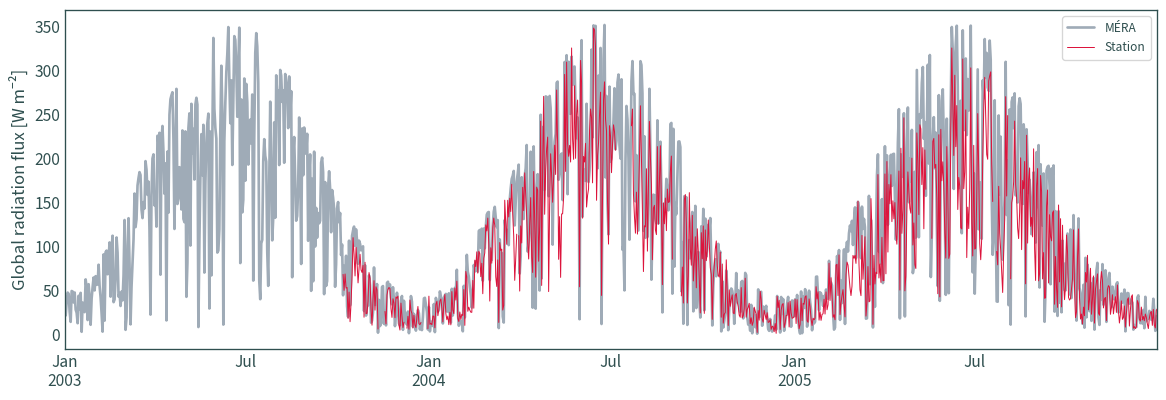

In [17]:
# plot
ax = data_df.plot(
    figsize=(12, 4.5), y=var,
    color="lightslategrey", alpha=.7, linewidth=2, label="MÉRA"
)
df_plot.plot(
    ax=ax, y="glorad", color="crimson", linewidth=.75, label="Station"
)
plt.tight_layout()
plt.ylabel(
    data_d[var].attrs["long_name"] + " [" + data_d[var].attrs["units"] + "]"
)
plt.xlabel("")
plt.show()

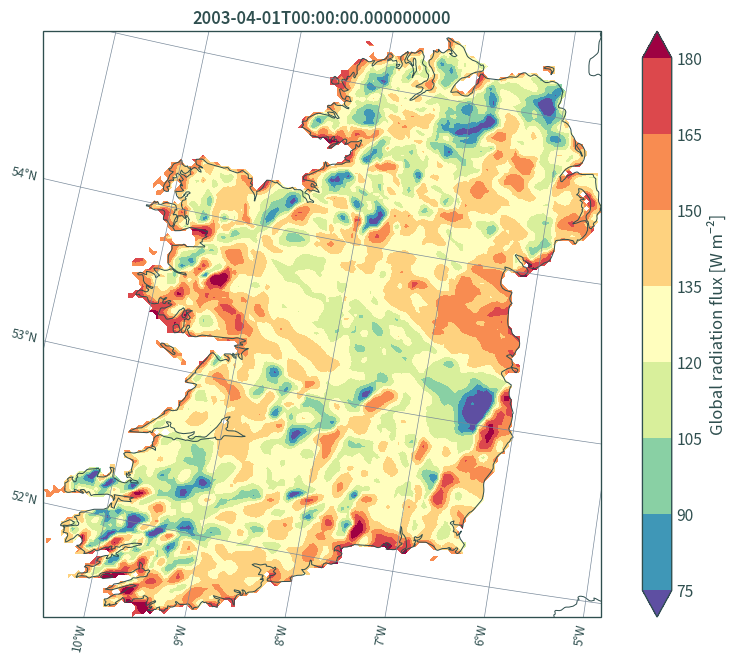

In [18]:
# map
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=cplt.lambert_conformal)
data_d.isel(time=90, height=0)[var].plot.contourf(
    ax=ax, robust=True, cmap="Spectral_r", x="x", y="y", levels=10,
    transform=cplt.lambert_conformal, cbar_kwargs={
        "label": (
            data_d[var].attrs["long_name"] +
            " [" + data_d[var].attrs["units"] + "]"
        )
    }
)
ax.gridlines(
    draw_labels=dict(bottom="x", left="y"),
    color="lightslategrey",
    linewidth=.5,
    x_inline=False,
    y_inline=False
)
ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
ax.set_title(str(data_d.isel(time=90, height=0)["time"].values))
plt.tight_layout()
plt.show()

## Total precipitation

In [19]:
var = "61_105_0_4"
file_list = list(chain(*list(
    glob.glob(os.path.join(DATA_DIR, f"{var}_FC3hr", e))
    for e in [f"*{i}*{var}_FC3hr*" for i in range(2003, 2006)]
)))
data = xr.open_mfdataset(file_list, chunks="auto", decode_coords="all")

In [20]:
data

<xarray.Dataset>
Dimensions:            (time: 8768, x: 158, y: 166, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31T21:00:00
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 0.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables:
    tp                 (time, height, y, x) float32 dask.array<chunksize=(248, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 18:03:40 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [21]:
# resample to daily - take the sum
var = "tp"
data_attrs = data[var].attrs
time_attrs = data["time"].attrs
data_crs = data.rio.crs
data_d = data.resample(time="D").sum()
data_d[var].attrs = data_attrs
data_d["time"].attrs = time_attrs
data_d[var].attrs["units"] = "mm day⁻¹"
data_d.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, height: 1, time: 1096)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    tp                 (time, height, y, x) float32 dask.array<chunksize=(1, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 18:03:40 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [22]:
# clip to Ireland's boundary to remove NaNs after summing
data_d = data_d.rio.clip(
    ie.buffer(1).to_crs(cplt.lambert_conformal), all_touched=True
)

In [23]:
data_d

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, height: 1, time: 1096)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    tp                 (time, height, y, x) float32 dask.array<chunksize=(1, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 18:03:40 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [24]:
# extract data for the nearest grid cell to the point
data_tsd = data_d.sel({"x": XLON, "y": YLAT}, method="nearest")

In [25]:
data_tsd

<xarray.Dataset>
Dimensions:            (height: 1, time: 1096)
Coordinates:
    x                  float64 5.8e+05
    y                  float64 4.725e+05
  * height             (height) float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    tp                 (time, height) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 18:03:40 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [26]:
# convert to dataframe for plotting
data_df = pd.DataFrame({"time": data_tsd["time"]})
data_df[f"{var}"] = data_tsd[var]
data_df.set_index("time", inplace=True)
# met data
df_plot = df[["rain"]].copy()
df_plot["rain"] = df_plot["rain"].astype(float)

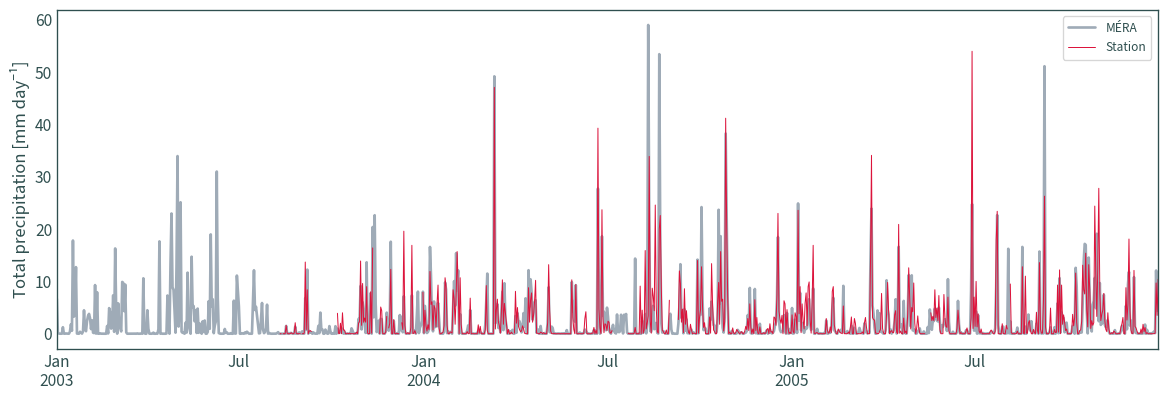

In [27]:
# plot
ax = data_df.plot(
    figsize=(12, 4.5), y=var,
    color="lightslategrey", alpha=.7, linewidth=2, label="MÉRA"
)
df_plot.plot(
    ax=ax, y="rain", color="crimson", linewidth=.75, label="Station"
)
plt.tight_layout()
plt.ylabel(
    data_d[var].attrs["long_name"] + " [" + data_d[var].attrs["units"] + "]"
)
plt.xlabel("")
plt.show()

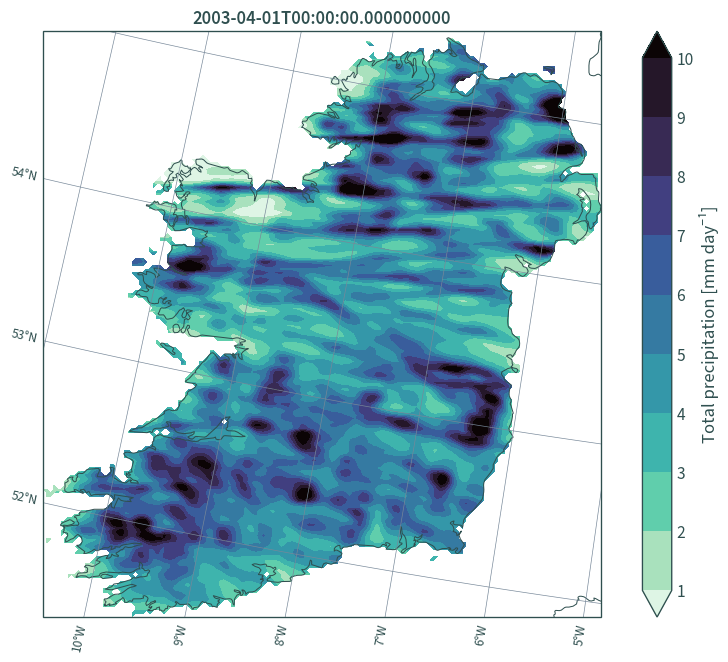

In [28]:
# map
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=cplt.lambert_conformal)
data_d.isel(time=90, height=0)[var].plot.contourf(
    ax=ax, robust=True, cmap=cplt.cmap_mako_r, x="x", y="y", levels=10,
    transform=cplt.lambert_conformal, cbar_kwargs={
        "label": (
            data_d[var].attrs["long_name"] +
            " [" + data_d[var].attrs["units"] + "]"
        )
    }
)
ax.gridlines(
    draw_labels=dict(bottom="x", left="y"),
    color="lightslategrey",
    linewidth=.5,
    x_inline=False,
    y_inline=False
)
ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
ax.set_title(str(data_d.isel(time=90, height=0)["time"].values))
plt.tight_layout()
plt.show()

## Maximum temperature

In [84]:
var = "15_105_2_2"
file_list = list(chain(*list(
    glob.glob(os.path.join(DATA_DIR, f"{var}_FC3hr", e))
    for e in [f"*{i}*{var}_FC3hr*" for i in range(2003, 2006)]
)))
data = xr.open_mfdataset(file_list, decode_coords="all", chunks="auto")

In [85]:
data

<xarray.Dataset>
Dimensions:            (time: 8768, x: 158, y: 166, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31T21:00:00
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 2.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables:
    tmax               (time, height, y, x) float32 dask.array<chunksize=(248, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 23:16:44 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [86]:
# convert to deg C
var = "tmax"
data_attrs = data[var].attrs
data_crs = data.rio.crs
data[var] = data[var] - 273.15

In [87]:
# resample to daily - take the max
time_attrs = data["time"].attrs
data_d = data.resample(time="D").max()
data_d[var].attrs = data_attrs  # reassign attributes
data_d["time"].attrs = time_attrs
data_d[var].attrs["units"] = "°C"  # update attributes
data_d.rio.write_crs(data_crs, inplace=True)  # reassign CRS

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, height: 1, time: 1096)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    tmax               (time, height, y, x) float32 dask.array<chunksize=(1, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 23:16:44 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [88]:
# extract data for the nearest grid cell to the point
data_tsd = data_d.sel({"x": XLON, "y": YLAT}, method="nearest")

In [89]:
data_tsd

<xarray.Dataset>
Dimensions:            (height: 1, time: 1096)
Coordinates:
    x                  float64 5.8e+05
    y                  float64 4.725e+05
  * height             (height) float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 2003-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    tmax               (time, height) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 23:16:44 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [90]:
# convert to dataframe for plotting
data_df = pd.DataFrame({"time": data_tsd["time"]})
data_df[f"{var}"] = data_tsd[var]
data_df.set_index("time", inplace=True)
# met data
df_plot = df[["maxtp"]].copy()
df_plot["maxtp"] = df_plot["maxtp"].astype(float)

/home/nms/miniconda3/envs/ClimAg/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


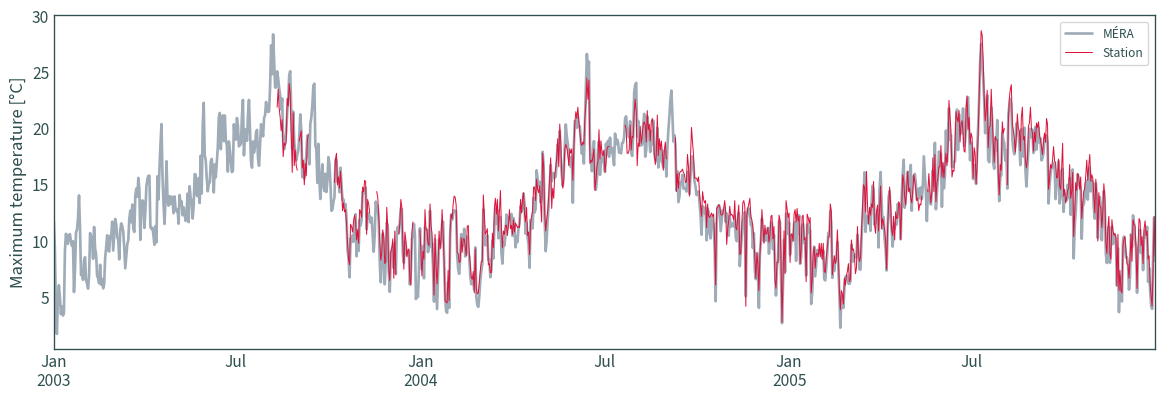

In [91]:
# plot
ax = data_df.plot(
    figsize=(12, 4.5), y=var,
    color="lightslategrey", alpha=.7, linewidth=2, label="MÉRA"
)
df_plot.plot(
    ax=ax, y="maxtp", color="crimson", linewidth=.75, label="Station"
)
plt.tight_layout()
plt.ylabel(
    data_d[var].attrs["long_name"] + " [" + data_d[var].attrs["units"] + "]"
)
plt.xlabel("")
plt.show()

/home/nms/miniconda3/envs/ClimAg/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


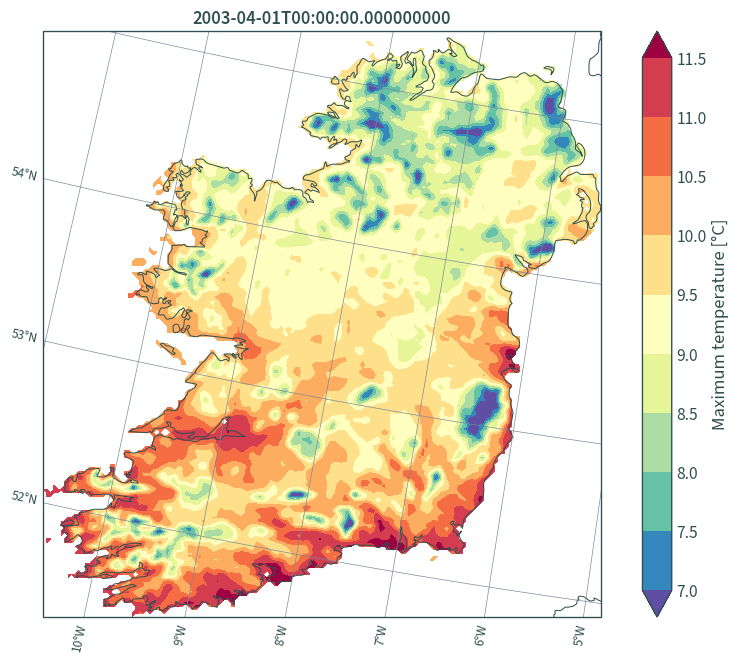

In [92]:
# map
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=cplt.lambert_conformal)
data_d.isel(time=90, height=0)[var].plot.contourf(
    ax=ax, robust=True, cmap="Spectral_r", x="x", y="y", levels=10,
    transform=cplt.lambert_conformal, cbar_kwargs={
        "label": (
            data_d[var].attrs["long_name"] +
            " [" + data_d[var].attrs["units"] + "]"
        )
    }
)
ax.gridlines(
    draw_labels=dict(bottom="x", left="y"),
    color="lightslategrey",
    linewidth=.5,
    x_inline=False,
    y_inline=False
)
ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
ax.set_title(str(data_d.isel(time=90, height=0)["time"].values))
plt.tight_layout()
plt.show()

In [93]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-03-23 18:19:41.704271+00:00
